# Application of text mining for understanding data protection incidents from penalty notices


## Introduction and imports

The research, written in relation to completion of the Master of Science, explores the possible application of text mining techniques in legal documents. The chosen theme was the penalty notices associated with data protection incidents that occurred after the introduction of the General Data Protection Regulation (GDPR) in 2016. The primary objectives of the research include identifying the common causes for data breaches and answering the question how these may influence the severity of the penalty given.



---
The goals of the notebook are:

*   Finding the connection between the penalties given and the content of the documents
*   Identifying common data breach causes




## Installing the necessary packages

In [36]:
import warnings
warnings.filterwarnings(
    "ignore",
    message=r"datetime\.datetime\.utcnow\(\) is deprecated.*",
    category=DeprecationWarning,
    module=r"jupyter_client\.session"
)

In [37]:
# SETUP: downloading necessary packages, after completion restarting is necessary in order to use the notebook
!pip install PyPDF2 pandas nltk spacy gensim scikit-learn matplotlib seaborn -q
!python -m spacy download en_core_web_sm
!pip install pyLDAvis
!pip install pymupdf


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 145.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [38]:
# IMPORTS: importing libraries to use
import os
import re
import PyPDF2
import pandas as pd
import nltk
from nltk.corpus import stopwords
from gensim import corpora, models
import spacy
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from google.colab import files
import nltk

# INIT: loading the trained pipeline for later use, setting up english stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nlp = spacy.load("en_core_web_sm")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data extraction


Due to having difficulties with downloading big zipfiles from Google Drive, manual upload was needed for the penalty notices

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The source for the files are https://www.enforcementtracker.com/, which is a GDPR penalty tracking website operated by a law firm. Both the text docuemnts and the meta information were extracted from their database, used as secondary source for the research.

The PDF files were collected manually, due to some of the links in the databse mot working. The xtract the metadata a PowerAutomated workflow was created for ease of scraping.

In [40]:
# Unzip the uploaded zip file
!unzip /content/drive/MyDrive/ENG_PDF.zip -d gdpr_pdfs

Archive:  /content/drive/MyDrive/ENG_PDF.zip
replace gdpr_pdfs/ETid-570.pdf? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace gdpr_pdfs/ETid-570.pdf? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: gdpr_pdfs/ETid-570.pdf  
  inflating: gdpr_pdfs/ETid-689.pdf  
  inflating: gdpr_pdfs/ETid-752.pdf  
  inflating: gdpr_pdfs/ETid-820.pdf  
  inflating: gdpr_pdfs/ETid-825.pdf  
  inflating: gdpr_pdfs/ETid-847.pdf  
  inflating: gdpr_pdfs/ETid-875.pdf  
  inflating: gdpr_pdfs/ETid-893.pdf  
  inflating: gdpr_pdfs/ETid-930.pdf  
  inflating: gdpr_pdfs/ETid-987.pdf  
  inflating: gdpr_pdfs/ETid-1009.pdf  
  inflating: gdpr_pdfs/ETid-1094.pdf  
  inflating: gdpr_pdfs/ETid-1188.pdf  
  inflating: gdpr_pdfs/ETid-1190.pdf  
  inflating: gdpr_pdfs/ETid-1250.pdf  
  inflating: gdpr_pdfs/ETid-1352.pdf  
  inflating: gdpr_pdfs/ETid-1373.pdf  
  inflating: gdpr_pdfs/ETid-1422.pdf  
  inflating: gdpr_pdfs/ETid-1461.pdf  
  inflating: gdpr_pdfs/ETid-1502.pdf  
  inflating:

In [41]:
from concurrent.futures import ProcessPoolExecutor
import fitz
import os

def extract_single_pdf(path):
    doc = fitz.open(path)
    text = "".join(page.get_text() for page in doc)
    doc.close()
    return os.path.basename(path), text

def extract_text_parallel(pdf_dir):
    pdf_paths = [os.path.join(pdf_dir, f) for f in os.listdir(pdf_dir) if f.endswith(".pdf")]

    with ProcessPoolExecutor() as executor:
        results = executor.map(extract_single_pdf, pdf_paths)

    return dict(results)

pdf_dir = "gdpr_pdfs"
texts = extract_text_parallel(pdf_dir)
print(f"Extracted {len(texts)} PDFs in parallel.")

Extracted 57 PDFs in parallel.


In [42]:
#Reading the extracted Engagement Tracker data into a dataframe
df_meta=pd.read_excel('/content/drive/MyDrive/ALL_metadata.xlsx', sheet_name='Sheet1')
df_meta.head()

,Unnamed: 0,ETid,Country,Authority,Date of Decision,Fine [€],Controller/Processor,Sector,Quoted Art.,Type,Summary,Source1,Source2
0,NaN,ETid-1911,MALTA,Data Protection Commissioner of Malta,2022,65000,Unknown,Not assigned,"Art. 5 (1) f) GDPR, Art. 6 (1) GDPR, Art. 9 (1...",Non-compliance with general data processing pr...,The controller has violated numerous GDPR regu...,link,https://www.enforcementtracker.com/ETid-1911 (...
1,NaN,ETid-1910,MALTA,Data Protection Commissioner of Malta,2023,2500,Unknown,Not assigned,"Art. 5 (1) a) GDPR, Art. 12 (1), (3) GDPR, Art...",Insufficient fulfilment of data subjects rights,Multiple data protection shortcomings,link,https://www.enforcementtracker.com/ETid-1910 (...
2,NaN,ETid-1909,MALTA,Data Protection Commissioner of Malta,2023,5000,Unknown,Not assigned,"Art. 5 (1) a), b), c) GDPR, Art. 6 GDPR",Non-compliance with general data processing pr...,The controller unlawfully gained access to aud...,link,https://www.enforcementtracker.com/ETid-1909 (...
3,NaN,ETid-1843,MALTA,Data Protection Commissioner of Malta,2020,4000,Unknown,Not assigned,"Art. 13 GDPR, Art. 15 GDPR, Regulation 9 S.L 5...",Insufficient fulfilment of data subjects rights,The controller had sent unsolicited commercial...,link,https://www.enforcementtracker.com/ETid-1843 (...
4,NaN,ETid-1842,MALTA,Data Protection Commissioner of Malta,2020,20000,Unknown,Not assigned,"Art. 13 GDPR, Art. 15 GDPR",Insufficient fulfilment of data subjects rights,The controller failed to comply with a data su...,link,https://www.enforcementtracker.com/ETid-1842 (...


# Exploratory data analysis

## Metadat setup

In [43]:
# prompt: help me filter the df_meta usiing the filename from texts on column Etid and replace the .pdf from filenames

def filter_and_replace(df, texts):
    """Filters the DataFrame based on filenames in 'texts' and replaces .pdf."""

    # Extract filenames without .pdf extension from the texts dictionary keys
    filenames_no_pdf = [filename[:-4] for filename in texts.keys()]

    # Filter the DataFrame to include only rows where 'Etid' is in the filenames
    df_filtered = df[df['ETid'].isin(filenames_no_pdf)]

    return df_filtered

# Apply the function
df_meta = filter_and_replace(df_meta, texts)

# Display the filtered DataFrame (optional)
df_meta.head()


,Unnamed: 0,ETid,Country,Authority,Date of Decision,Fine [€],Controller/Processor,Sector,Quoted Art.,Type,Summary,Source1,Source2
1,NaN,ETid-1910,MALTA,Data Protection Commissioner of Malta,2023,2500,Unknown,Not assigned,"Art. 5 (1) a) GDPR, Art. 12 (1), (3) GDPR, Art...",Insufficient fulfilment of data subjects rights,Multiple data protection shortcomings,link,https://www.enforcementtracker.com/ETid-1910 (...
14,NaN,ETid-1352,ISLE OF MAN,Information Commissioner of Isle of Man,2022-07-13 00:00:00,202000,Manx Care Ltd,Health Care,"Art. 5 (1) c), f) GDPR, Art. 5 (2) GDPR, Art. ...",Non-compliance with general data processing pr...,The DPA of Isle of Man has imposed a fine of E...,link link,https://www.enforcementtracker.com/ETid-1352 (...
15,NaN,ETid-847,ISLE OF MAN,Information Commissioner of Isle of Man,2020-12-11 00:00:00,3250,Cosmetic Medical Limited,Industry and Commerce,Art. 31 GDPR,Insufficient cooperation with supervisory auth...,The DPA of Isle of Man has imposed a fine of E...,link,https://www.enforcementtracker.com/ETid-847 (C...
16,NaN,ETid-318,ISLE OF MAN,Information Commissioner of Isle of Man,2020-06-25 00:00:00,13500,Department of Home Affairs,Public Sector and Education,"Art. 12 GDPR, Art. 15 GDPR",Insufficient fulfilment of data subjects rights,Fines for failure to comply with the right of ...,link,https://www.enforcementtracker.com/ETid-318 (C...
17,NaN,ETid-2780,IRELAND,Data Protection Authority of Ireland,2024-11-22 00:00:00,40000,Maynooth University,Public Sector and Education,"Art. 5 (1) f) GDPR, Art. 32 (1) GDPR, Art. 33 ...",Insufficient technical and organisational meas...,"The Irish DPA has imposed a fine of EUR 40,000...",link link,https://www.enforcementtracker.com/ETid-2780 (...


In [44]:
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
Index: 57 entries, 1 to 73
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            0 non-null      float64
 1   ETid                  57 non-null     object 
 2   Country               57 non-null     object 
 3   Authority             57 non-null     object 
 4   Date of Decision      57 non-null     object 
 5   Fine [€]              57 non-null     object 
 6   Controller/Processor  57 non-null     object 
 7   Sector                57 non-null     object 
 8   Quoted Art.           57 non-null     object 
 9   Type                  57 non-null     object 
 10  Summary               57 non-null     object 
 11  Source1               57 non-null     object 
 12  Source2               57 non-null     object 
dtypes: float64(1), object(12)
memory usage: 8.3+ KB


From calling the info() function we can see that all data is objects, which is not optimal for further analysis. The data should have contained float for the fees and datetime for the date of decision

In [45]:
df_meta['Fine [€]'].unique()

array([2500, 202000, 3250, 13500, 40000, 29500, 125000, 550000, 530000000,
       251000000, 310000000, 91000000, 345000000, 22500, 1200000000,
       750000, 15000, 460000, 5500000, 100000, 390000000, 5000, 265000000,
       405000000, 17000000, 110000, 60000, 1500,
       'Only intention to issue fine', 1400, 225000000, 90000, 85000,
       70000, 450000, 75000, 6880000, 9180000, 230, 20725, 2700000, 70300,
       3500000, 904000, 8700, 400000, 14500000, 5033000, 1547000, 91000,
       9000000, 115000, 585000, 29000, 1405000, 20450000], dtype=object)

From the unique values, the problem is apparent that there is a string within the fees, which will be set to 0 as the decision was not made.

In [46]:
df_meta['Fine [€]'].replace('Only intention to issue fine', 0, inplace=True)

/tmp/ipython-input-46-319294056.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_meta['Fine [€]'].replace('Only intention to issue fine', 0, inplace=True)
/tmp/ipython-input-46-319294056.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_meta['Fine [€]'].replace('Only intention to issue fi

Getting the unique values for each breached article column returns a messy dataset. To fix this the column has to be spli first, then "exploded" into multiple rows.

In [47]:
df_meta['Quoted Art.'].unique()

array(['Art. 5 (1) a) GDPR, Art. 12 (1), (3) GDPR, Art. 13 GDPR, Art. 14 GDPR, Art. 15 (1), (3) GDPR, Art. 24 (2) GDPR, Art. 38 (1) GDPR',
       'Art. 5 (1) c), f) GDPR, Art. 5 (2) GDPR, Art. 24 GDPR, Art. 25 GDPR, Art. 32 GDPR, Art. 34 GDPR, Art. 58 GDPR',
       'Art. 31 GDPR', 'Art. 12 GDPR, Art. 15 GDPR',
       'Art. 5 (1) f) GDPR, Art. 32 (1) GDPR, Art. 33 (1) GDPR',
       'Art. 5 (1) a), c), e), f) GDPR, Art. 13 (1), (3) GDPR, Art. 24 (1) GDPR, Art. 25 GDPR, Art. 30 GDPR, Art. 32 (1) GDPR',
       'Art. 5 (1) f) GDPR, Art. 32 (1), (2) GDPR, Art. 33 (1) GDPR, Art. 34 (1), (4) GDPR',
       'Art. 5 (1) a), e) GDPR, Art. 6 (1) GDPR, Art. 9 (1) GDPR, Art. 13 (1) c) GDPR, Art. 13 (2) a) GDPR, Art. 35 (VII) b), c) GDPR',
       'Art. 13 (1) f) GDPR, Art. 46 (1) GDPR',
       'Art. 33 (3), (5) GDPR, Art. 25 (1), (2) GDPR',
       'Art. 5 (1) a) GDPR, Art. 6 (1) a), e), f) GDPR, Art. 13 (1) c) GDPR, Art. 14 (1) c) GDPR',
       'Art. 5 (1) f) GDPR, Art. 32 (1) GDPR, Art. 33 (1), (5) G

In [48]:
# Clean metadata - drop 'Unnamed', 'Source1', 'Source2'
metadata_df_cleaned = df_meta.drop(columns=[col for col in df_meta.columns if 'Unnamed' in col or col in ['Source1', 'Source2']])

# Normalize 'Quoted Art.' column by splitting and exploding
metadata_df_cleaned['Quoted Art.'] = metadata_df_cleaned['Quoted Art.'].fillna('Unknown')
metadata_df_cleaned['Quoted Art.'] = metadata_df_cleaned['Quoted Art.'].str.replace('Art. ', '', regex=False)
metadata_df_cleaned['Quoted Art.'] = metadata_df_cleaned['Quoted Art.'].str.split(', ')
metadata_exploded = metadata_df_cleaned.explode('Quoted Art.')
metadata_exploded['Quoted Art.'] = 'Art. ' + metadata_exploded['Quoted Art.'].str.strip()

# Create a simplified version
# Keep only the base article (e.g., 'Art. 5', 'Art. 6') and remove subpoints like (1), (2), a), b), etc.
metadata_exploded['Quoted Art. Simple'] = metadata_exploded['Quoted Art.'].str.extract(r'(Art\.\s*\d+)')
metadata_exploded = metadata_exploded.dropna()

From the exploded rows NULL values are dropped as they are related to the same article, but due to splitting with commas the second subsection is incorrecly empty. Dropping is preferred here as using forward filling creates duplicates.

In [49]:
metadata_exploded.head()

,ETid,Country,Authority,Date of Decision,Fine [€],Controller/Processor,Sector,Quoted Art.,Type,Summary,Quoted Art. Simple
1,ETid-1910,MALTA,Data Protection Commissioner of Malta,2023,2500,Unknown,Not assigned,Art. 5 (1) a) GDPR,Insufficient fulfilment of data subjects rights,Multiple data protection shortcomings,Art. 5
1,ETid-1910,MALTA,Data Protection Commissioner of Malta,2023,2500,Unknown,Not assigned,Art. 12 (1),Insufficient fulfilment of data subjects rights,Multiple data protection shortcomings,Art. 12
1,ETid-1910,MALTA,Data Protection Commissioner of Malta,2023,2500,Unknown,Not assigned,Art. 13 GDPR,Insufficient fulfilment of data subjects rights,Multiple data protection shortcomings,Art. 13
1,ETid-1910,MALTA,Data Protection Commissioner of Malta,2023,2500,Unknown,Not assigned,Art. 14 GDPR,Insufficient fulfilment of data subjects rights,Multiple data protection shortcomings,Art. 14
1,ETid-1910,MALTA,Data Protection Commissioner of Malta,2023,2500,Unknown,Not assigned,Art. 15 (1),Insufficient fulfilment of data subjects rights,Multiple data protection shortcomings,Art. 15


Simple group by to see and understand the data using simple statistical measures.

In [50]:
# Group by simplified article and calculate summary statistics
article_summary = metadata_exploded.groupby('Quoted Art. Simple').agg(
    total_fines=('Fine [€]', 'sum'),
    average_fine=('Fine [€]', 'mean'),
    case_count=('Fine [€]', 'count')
).reset_index().sort_values(by='total_fines', ascending=False)

print(article_summary)

   Quoted Art. Simple  total_fines  average_fine  case_count
19             Art. 5   2176433725  5.181985e+07          42
1             Art. 13   1822789000  1.301992e+08          14
18            Art. 46   1730000000  8.650000e+08           2
0             Art. 12   1385126000  1.385126e+08          10
9             Art. 25   1266321500  1.809031e+08           7
21             Art. 6   1121694500  1.246327e+08           9
8             Art. 24    767329000  9.591612e+07           8
2             Art. 14    544002500  1.360006e+08           4
16            Art. 35    414550000  1.381833e+08           3
14            Art. 33    342876025  3.428760e+07          10
13            Art. 32    143799725  5.135704e+06          28
22             Art. 9     11119500  2.779875e+06           4
3             Art. 15      9126000  2.281500e+06           4
6             Art. 21      9001400  4.500700e+06           2
4             Art. 16      9000000  9.000000e+06           1
5             Art. 17   

Creating plots for the research pape to visualize the top and bottom 5 artciles by total and averga e fines.

/tmp/ipython-input-51-3837431429.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top5, x='total_fines', y='Quoted Art. Simple', palette='Greens_d', ax=ax1)
/tmp/ipython-input-51-3837431429.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bottom5, x='total_fines', y='Quoted Art. Simple', palette='Reds_d', ax=ax2)


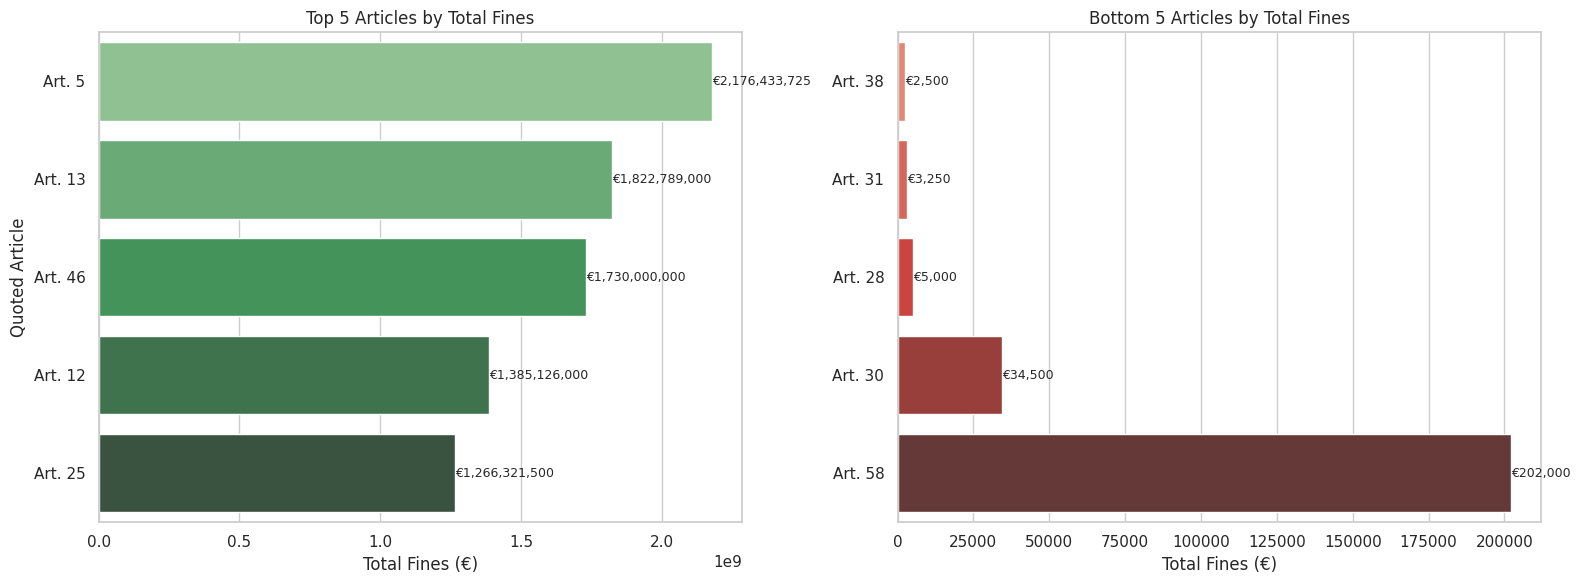

In [51]:
# Prepare top and bottom 5
top5 = article_summary.nlargest(5, 'total_fines')
bottom5 = article_summary.nsmallest(5, 'total_fines')

sns.set(style="whitegrid")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Top 5
sns.barplot(data=top5, x='total_fines', y='Quoted Art. Simple', palette='Greens_d', ax=ax1)
ax1.set_title('Top 5 Articles by Total Fines')
ax1.set_xlabel('Total Fines (€)')
ax1.set_ylabel('Quoted Article')
for bar, value in zip(ax1.patches, top5['total_fines']):
    ax1.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f"€{value:,.0f}",
             va='center', ha='left', fontsize=9)

# Bottom 5
sns.barplot(data=bottom5, x='total_fines', y='Quoted Art. Simple', palette='Reds_d', ax=ax2)
ax2.set_title('Bottom 5 Articles by Total Fines')
ax2.set_xlabel('Total Fines (€)')
ax2.set_ylabel('')
for bar, value in zip(ax2.patches, bottom5['total_fines']):
    ax2.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f"€{value:,.0f}",
             va='center', ha='left', fontsize=9)

plt.tight_layout()
plt.show()


/tmp/ipython-input-52-2016014625.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top5, x='average_fine', y='Quoted Art. Simple', palette='Greens_d', ax=ax1)
/tmp/ipython-input-52-2016014625.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bottom5, x='average_fine', y='Quoted Art. Simple', palette='Reds_d', ax=ax2)


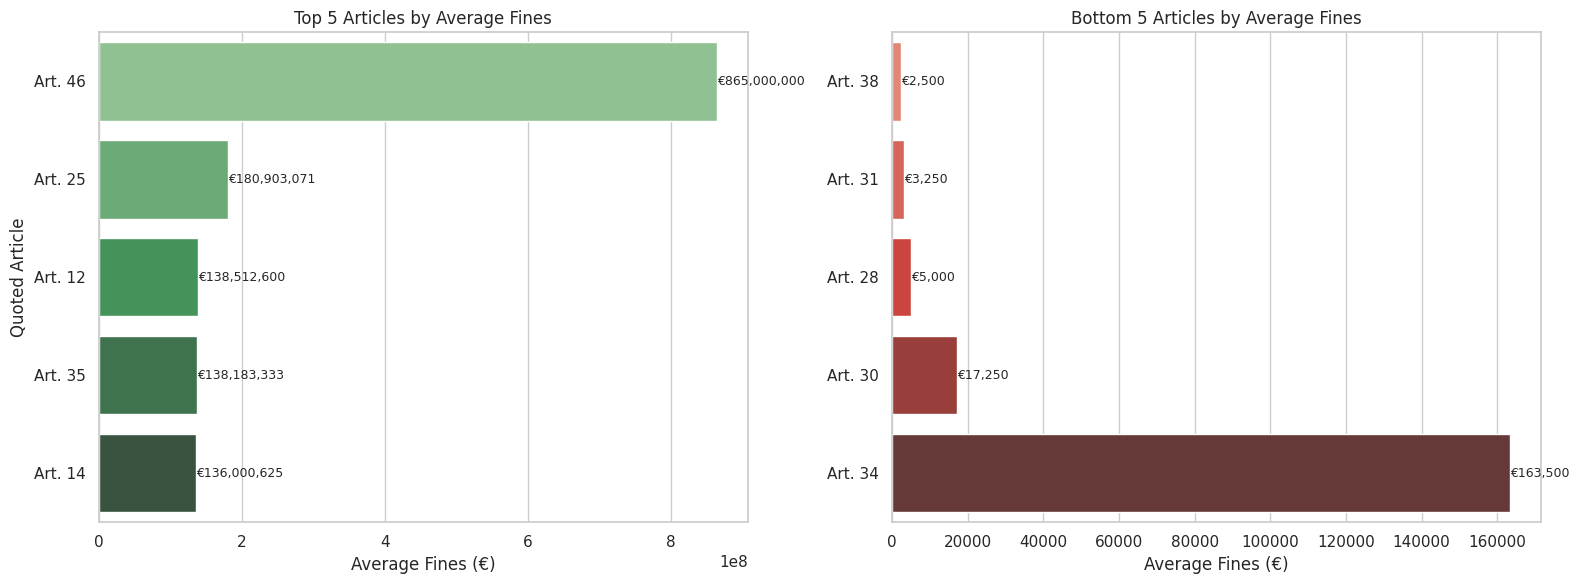

In [52]:
# Prepare top and bottom 5
top5 = article_summary.nlargest(5, 'average_fine')
bottom5 = article_summary.nsmallest(5, 'average_fine')

sns.set(style="whitegrid")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Top 5
sns.barplot(data=top5, x='average_fine', y='Quoted Art. Simple', palette='Greens_d', ax=ax1)
ax1.set_title('Top 5 Articles by Average Fines')
ax1.set_xlabel('Average Fines (€)')
ax1.set_ylabel('Quoted Article')
for bar, value in zip(ax1.patches, top5['average_fine']):
    ax1.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f"€{value:,.0f}",
             va='center', ha='left', fontsize=9)

# Bottom 5
sns.barplot(data=bottom5, x='average_fine', y='Quoted Art. Simple', palette='Reds_d', ax=ax2)
ax2.set_title('Bottom 5 Articles by Average Fines')
ax2.set_xlabel('Average Fines (€)')
ax2.set_ylabel('')
for bar, value in zip(ax2.patches, bottom5['average_fine']):
    ax2.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f"€{value:,.0f}",
             va='center', ha='left', fontsize=9)

plt.tight_layout()
plt.show()


Another simple visulization for the paper using value_counts.

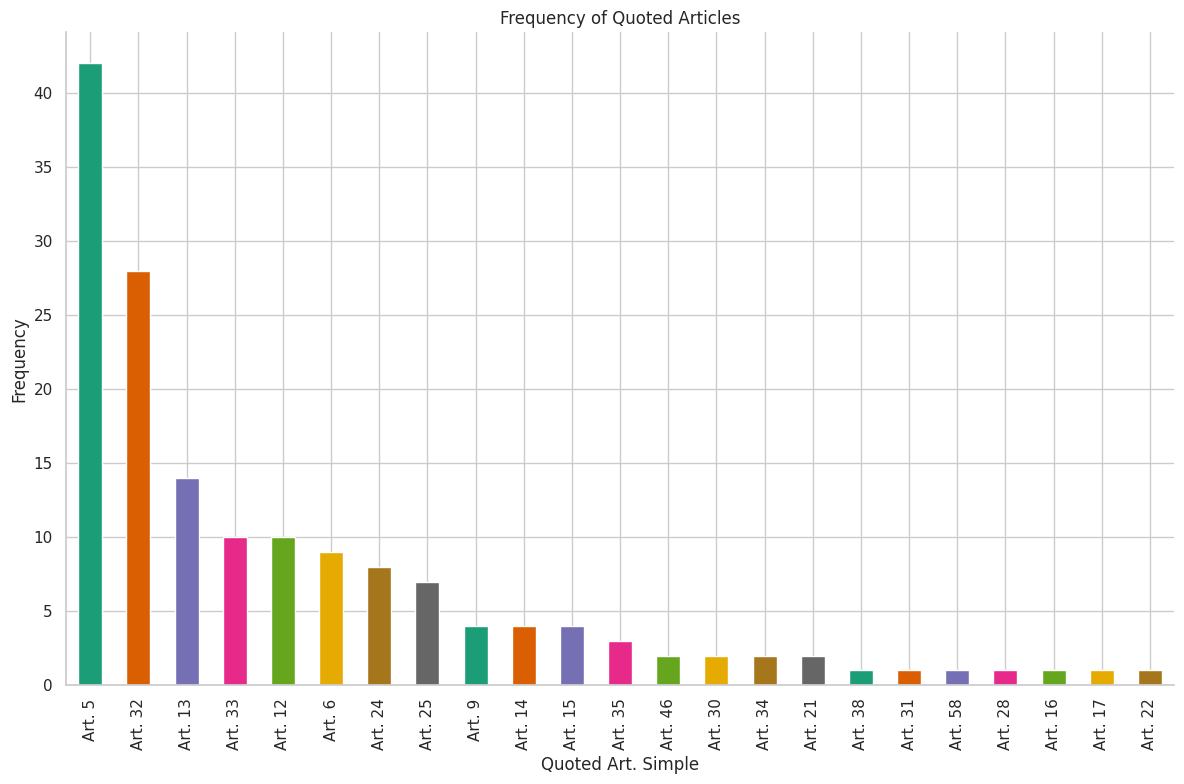

In [53]:
plt.figure(figsize=(12, 8))

# Count the occurrences of each article and plot as bar
article_counts = metadata_exploded['Quoted Art. Simple'].value_counts()

article_counts.plot(
    kind='bar',
    color=sns.color_palette('Dark2')
)

# Add labels and title
plt.title('Frequency of Quoted Articles')
plt.xlabel('Quoted Art. Simple')
plt.ylabel('Frequency')

# Improve readability
plt.xticks(rotation=90)
plt.gca().spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

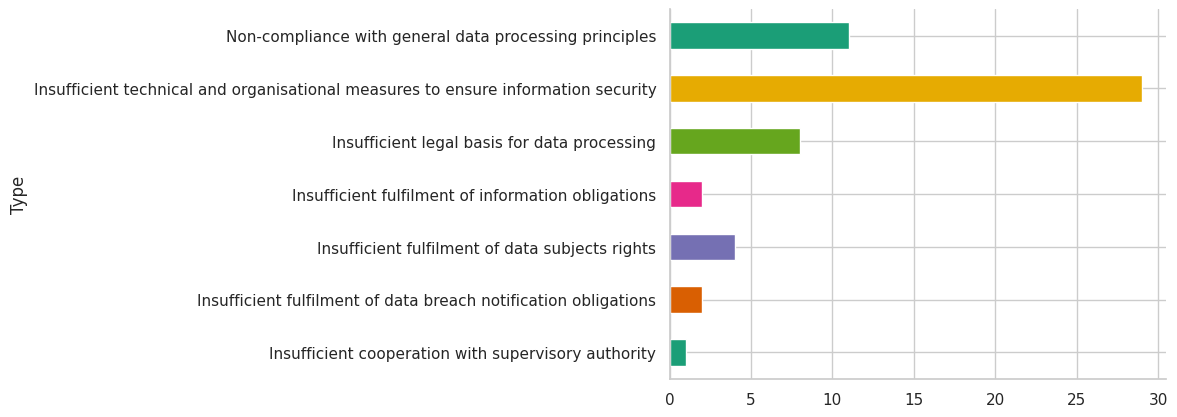

In [54]:
from matplotlib import pyplot as plt
import seaborn as sns
metadata_df_cleaned.groupby('Type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

## Keyword frequency

From the articles used and the wordcloud ran throughout the developement of the notebook a keyword frequency table is created using count.

In [55]:
# Keyword frequency analysis
def keyword_frequency(text, keywords):
    return {kw: text.lower().count(kw) for kw in keywords}

keywords = ['monitoring', 'encryption', 'access control', 'destruct', 'logging', 'transfer',
            'privacy', 'rights', 'vulnerability', 'child', 'personal data', 'breach', 'risk']

keyword_df = pd.DataFrame(
    [keyword_frequency(text, keywords) for text in texts.values()],
    index=texts.keys()
)
keyword_df.to_csv('keyword_frequency.csv')
keyword_df.style.background_gradient(cmap='Blues')

,monitoring,encryption,access control,destruct,logging,transfer,privacy,rights,vulnerability,child,personal data,breach,risk
ETid-930.pdf,3,1,0,3,0,3,1,8,1,0,37,56,19
ETid-2484.pdf,0,0,0,0,0,0,0,1,3,1,5,8,3
ETid-1564.pdf,1,5,0,3,1,5,0,27,0,0,107,88,105
ETid-893.pdf,0,0,0,0,0,0,0,0,0,1,5,3,1
ETid-1677.pdf,6,4,4,2,1,0,0,17,17,0,144,127,59
ETid-1910.pdf,0,1,0,0,0,0,16,32,0,23,70,1,2
ETid-1009.pdf,158,0,0,4,0,6,26,48,0,0,252,1,22
ETid-2561.pdf,0,1,0,0,0,0,0,2,45,0,19,3,12
ETid-2566.pdf,0,2,0,3,0,1,3,15,1,15,107,47,47
ETid-2885.pdf,0,0,0,0,0,0,0,0,0,0,1,0,0


After the writing the keywords frequency to a csv file, the data can be read into a dataframe to avoid uploading and extarcting each PDF again.

In [56]:
keywords_df = pd.read_csv('keyword_frequency.csv')

In [57]:
keywords_df.head()

,Unnamed: 0,monitoring,encryption,access control,destruct,logging,transfer,privacy,rights,vulnerability,child,personal data,breach,risk
0,ETid-930.pdf,3,1,0,3,0,3,1,8,1,0,37,56,19
1,ETid-2484.pdf,0,0,0,0,0,0,0,1,3,1,5,8,3
2,ETid-1564.pdf,1,5,0,3,1,5,0,27,0,0,107,88,105
3,ETid-893.pdf,0,0,0,0,0,0,0,0,0,1,5,3,1
4,ETid-1677.pdf,6,4,4,2,1,0,0,17,17,0,144,127,59


Joining the exploded metadata through the filename by replacing the file extension.

In [58]:
metadata_exploded['ETid'] = metadata_exploded['ETid'].astype(str).str.strip() + '.pdf'

merged_df = metadata_exploded.merge(keywords_df, left_on='ETid', right_on='Unnamed: 0')

In [59]:
merged_df.head()

,ETid,Country,Authority,Date of Decision,Fine [€],Controller/Processor,Sector,Quoted Art.,Type,Summary,...,destruct,logging,transfer,privacy,rights,vulnerability,child,personal data,breach,risk
0,ETid-1910.pdf,MALTA,Data Protection Commissioner of Malta,2023,2500,Unknown,Not assigned,Art. 5 (1) a) GDPR,Insufficient fulfilment of data subjects rights,Multiple data protection shortcomings,...,0,0,0,16,32,0,23,70,1,2
1,ETid-1910.pdf,MALTA,Data Protection Commissioner of Malta,2023,2500,Unknown,Not assigned,Art. 12 (1),Insufficient fulfilment of data subjects rights,Multiple data protection shortcomings,...,0,0,0,16,32,0,23,70,1,2
2,ETid-1910.pdf,MALTA,Data Protection Commissioner of Malta,2023,2500,Unknown,Not assigned,Art. 13 GDPR,Insufficient fulfilment of data subjects rights,Multiple data protection shortcomings,...,0,0,0,16,32,0,23,70,1,2
3,ETid-1910.pdf,MALTA,Data Protection Commissioner of Malta,2023,2500,Unknown,Not assigned,Art. 14 GDPR,Insufficient fulfilment of data subjects rights,Multiple data protection shortcomings,...,0,0,0,16,32,0,23,70,1,2
4,ETid-1910.pdf,MALTA,Data Protection Commissioner of Malta,2023,2500,Unknown,Not assigned,Art. 15 (1),Insufficient fulfilment of data subjects rights,Multiple data protection shortcomings,...,0,0,0,16,32,0,23,70,1,2


Plotting notable keyords against the amount of fine given.

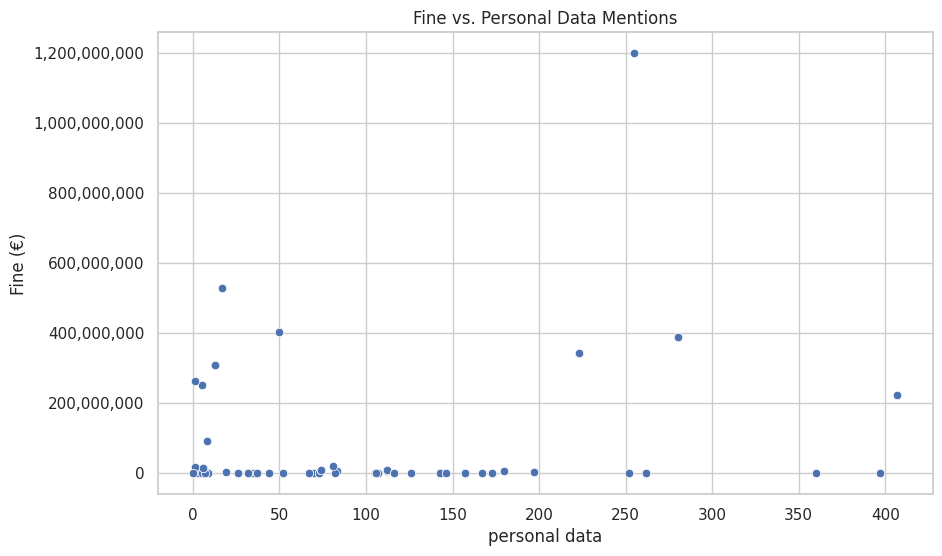

In [60]:
plt.figure(figsize=(10, 6))
# Create the scatter plot with Seaborn
scatter_plot = sns.scatterplot(data=merged_df, x='personal data', y='Fine [€]')

# Format y-axis labels to display full numbers instead of scientific notation
scatter_plot.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

# Add a y-axis label
plt.ylabel('Fine (€)')

plt.title('Fine vs. Personal Data Mentions')
plt.show()

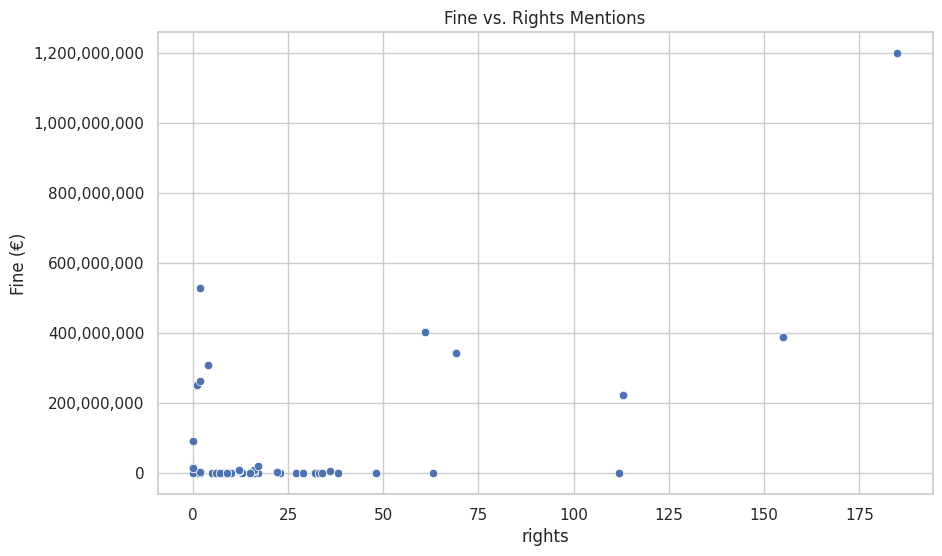

In [61]:
plt.figure(figsize=(10, 6))
# Create the scatter plot with Seaborn
scatter_plot = sns.scatterplot(data=merged_df, x='rights', y='Fine [€]')

# Format y-axis labels to display full numbers instead of scientific notation
scatter_plot.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

# Add a y-axis label
plt.ylabel('Fine (€)')

plt.title('Fine vs. Rights Mentions')
plt.show()

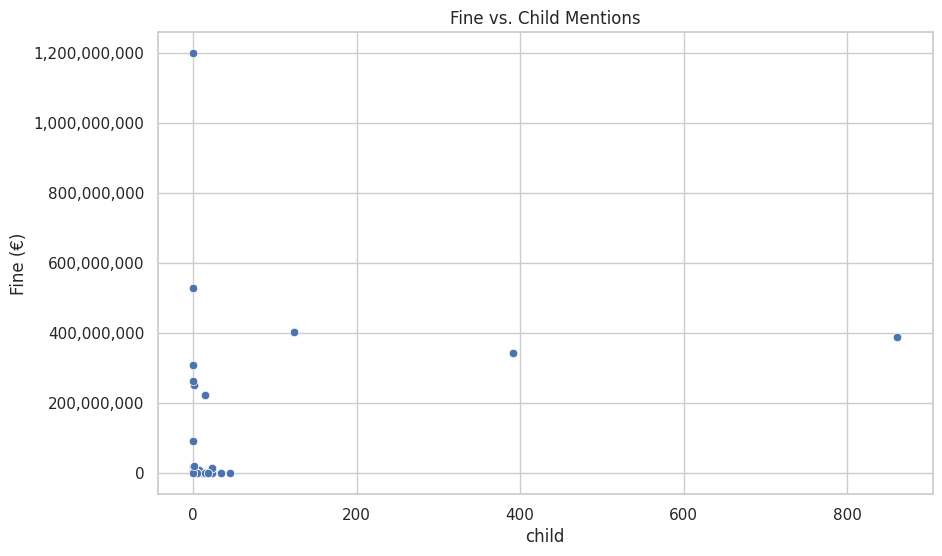

In [62]:
plt.figure(figsize=(10, 6))
# Create the scatter plot with Seaborn
scatter_plot = sns.scatterplot(data=merged_df, x='child', y='Fine [€]')

# Format y-axis labels to display full numbers instead of scientific notation
scatter_plot.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

# Add a y-axis label
plt.ylabel('Fine (€)')

plt.title('Fine vs. Child Mentions')
plt.show()

## Wordcloud generation

Getting the raw text by tokenization from each document.

In [63]:
def get_text(text):
    doc = nlp(text.lower())
    tokens = [
        token.lemma_ for token in doc
    ]
    return tokens

For each document the script extacts the text and joins it into a varibale to generate a world cloud based on frequency.

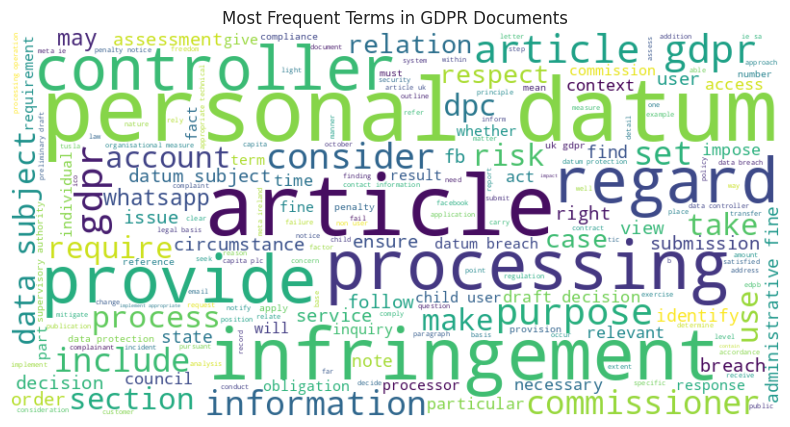

In [64]:
# Convert each PDF's text into token list
raw_texts = [get_text(text) for text in texts.values()]

# Flatten all PDFs into one token list
all_tokens = [tok for doc in raw_texts for tok in doc if tok.isalpha()]

# Convert to single string
text_string = " ".join(all_tokens)

# Generate wordcloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_string)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Frequent Terms in GDPR Documents")
plt.show()

The same function get_text, but expanded to exclude the stopwords and tokens less than 2 characters.

In [65]:
def clean_text(text):
    doc = nlp(text.lower())
    tokens = [
        token.lemma_ for token in doc
        if token.is_alpha and not token.is_stop and len(token) > 2
    ]
    return tokens

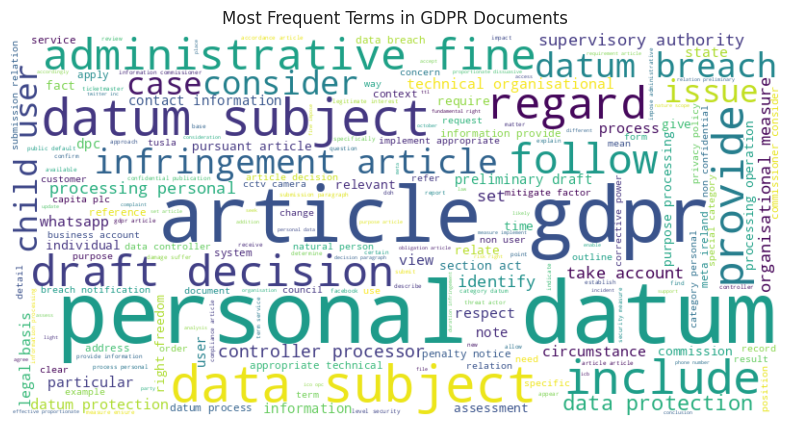

In [66]:
# Convert each PDF's text into token list
cleaned_texts = [clean_text(text) for text in texts.values()]

# Flatten all PDFs into one token list
all_tokens = [tok for doc in cleaned_texts for tok in doc if tok.isalpha()]

# Convert to single string
text_string = " ".join(all_tokens)

# Generate wordcloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_string)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Frequent Terms in GDPR Documents")
plt.show()

We saw many companies and entites within the world cloud appearing. To find out if they are connected to the highest penalties, the top 10 is used in the wordcloud.

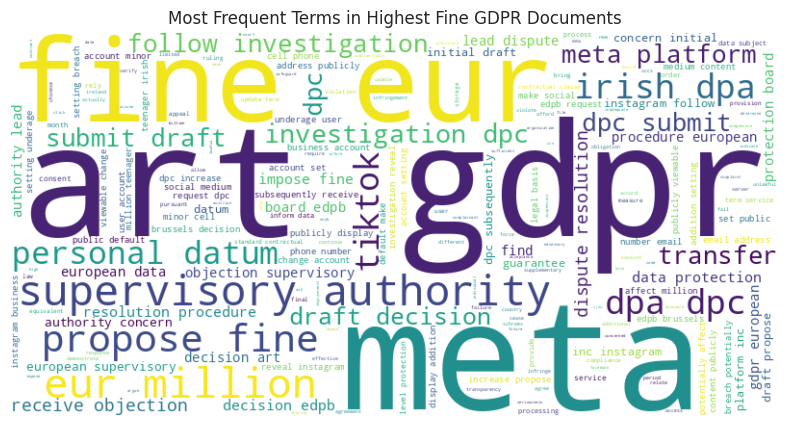

In [67]:
# Filter for highest fines
highest_fines_df = merged_df.nlargest(10, 'Fine [€]') # Select top 10 based on Fine column

# Combine text from highest fine documents
text_string = " ".join(highest_fines_df['Summary'].astype(str).tolist())

cleaned_text = clean_text(text_string)  # Example assuming 'clean_text' function is available
text_string = " ".join(cleaned_text)

# Create and display the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_string)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Frequent Terms in Highest Fine GDPR Documents")
plt.show()

## Text length and N-gram analysis

A combanation of functions to explore how the dataset is structured. The compute_text_stats function creates a list and iterates through the documents splitting the text, while counting the number of words and letters, then dividing the two returns the average word length.
The visualize_stats function takes these statistics and creates plots using the Filename as key.
The following function removes the stopwords and uses the CountVectorizer to transfrom the text into N-grams with the counts variable to store the number of the N-gram appears. Defining a list with the number of N-grams examined, within a for loop the fucntion returns in our case the mono-, bi- and trigrams.

         filename  num_words  num_chars  avg_word_length
0    ETid-930.pdf       9373      59187         6.314627
1   ETid-2484.pdf        911       6326         6.944018
2   ETid-1564.pdf      16481     110258         6.690007
3    ETid-893.pdf        353       2293         6.495751
4   ETid-1677.pdf      10505      69165         6.584008
5   ETid-1910.pdf      11135      68576         6.158599
6   ETid-1009.pdf      41534     264064         6.357779
7   ETid-2561.pdf       4947      32978         6.666262
8   ETid-2566.pdf      13732      89159         6.492791
9   ETid-2885.pdf        275       2091         7.603636
10  ETid-2657.pdf       1012       7036         6.952569
11    ETid-60.pdf      30191     195363         6.470902
12  ETid-2032.pdf      52109     326607         6.267766
13  ETid-1190.pdf       9843      62089         6.307935
14   ETid-875.pdf      44014     284046         6.453538
15  ETid-2684.pdf        866       5743         6.631640
16  ETid-1696.pdf      10014   

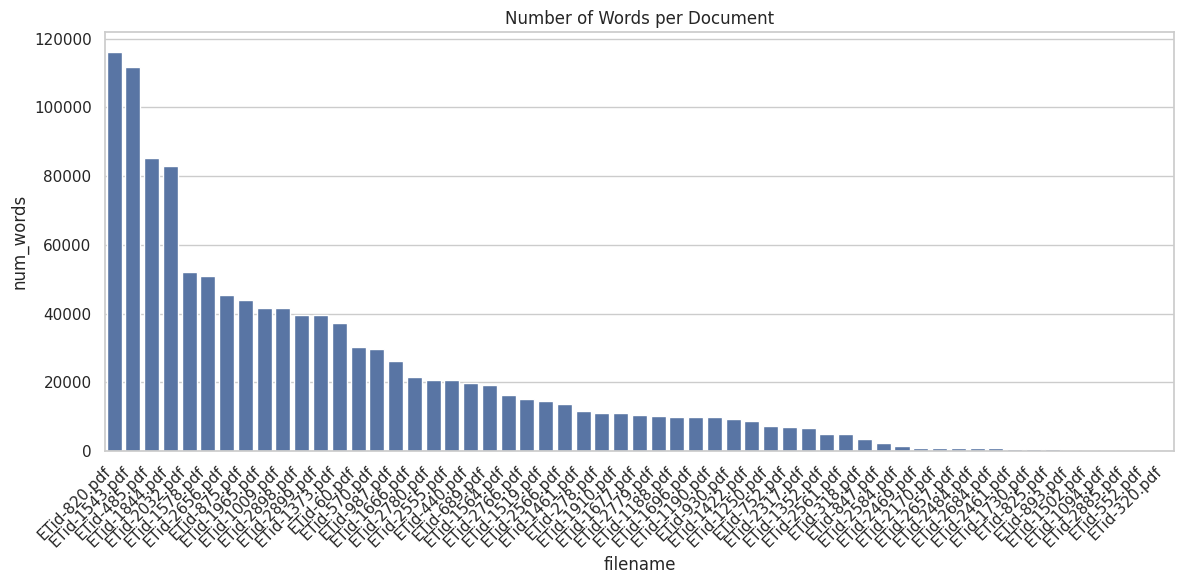

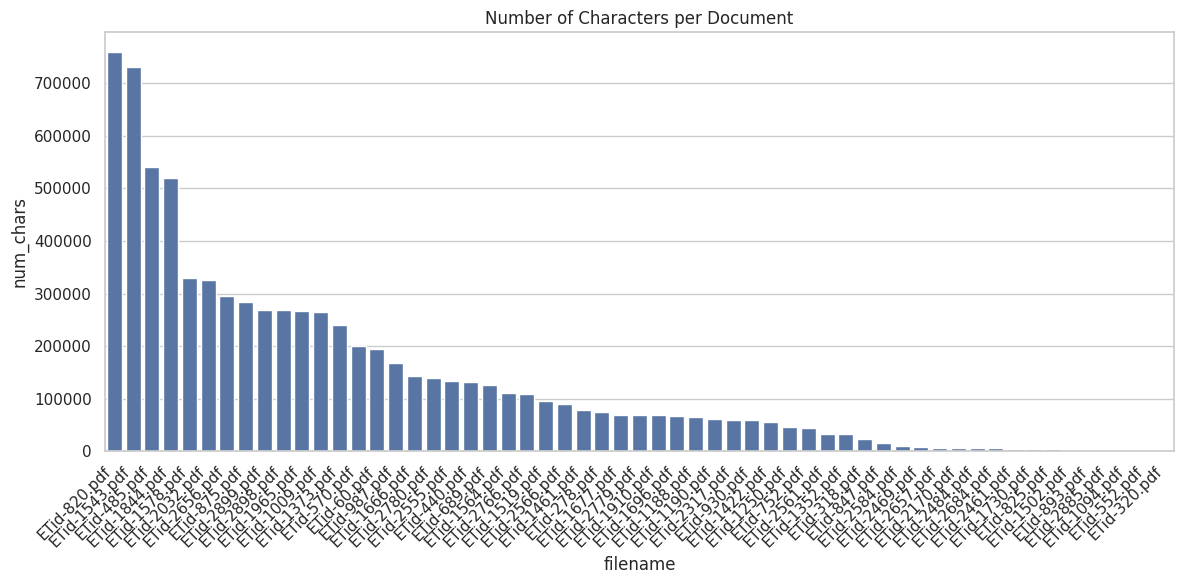


Top 10 1-grams:
data: 15509
article: 8858
gdpr: 7285
personal: 6264
processing: 6202
information: 4919
decision: 4001
commissioner: 3722
controller: 3103
breach: 3023

Top 10 2-grams:
personal data: 5975
data subjects: 2134
data protection: 1629
article 83: 1622
data breach: 1263
draft decision: 1157
data subject: 1076
article gdpr: 1058
processing personal: 961
article 33: 917

Top 10 3-grams:
processing personal data: 950
personal data breach: 887
article 83 gdpr: 729
technical organisational measures: 701
appropriate technical organisational: 437
article 65 decision: 370
non confidential publication: 338
categories personal data: 321
personal data processed: 307
number data subjects: 286


In [68]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

# Compute text statistics
def compute_text_stats(texts):
    stats = []
    for filename, text in texts.items():
        words = text.split()
        stats.append({
            'filename': filename,
            'num_words': len(words),
            'num_chars': len(text),
            'avg_word_length': len(text) / len(words) if words else 0
        })
    return pd.DataFrame(stats)

# Visualize text stats
def visualize_stats(stats_df):
    plt.figure(figsize=(12, 6))
    sns.barplot(data=stats_df.sort_values(by='num_words', ascending=False), x='filename', y='num_words')
    plt.xticks(rotation=45, ha='right')
    plt.title("Number of Words per Document")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.barplot(data=stats_df.sort_values(by='num_chars', ascending=False), x='filename', y='num_chars')
    plt.xticks(rotation=45, ha='right')
    plt.title("Number of Characters per Document")
    plt.tight_layout()
    plt.show()

# N-gram Extraction (top 10 for each n)
def get_top_ngrams(texts, n=2, top_k=10):
    vectorizer = CountVectorizer(ngram_range=(n, n), stop_words='english')
    all_text = list(texts.values())
    X = vectorizer.fit_transform(all_text)
    counts = X.sum(axis=0).A1
    ngram_freq = dict(zip(vectorizer.get_feature_names_out(), counts))
    return Counter(ngram_freq).most_common(top_k)

# Run
# Stats & Visuals
stats_df = compute_text_stats(texts)
print(stats_df)
visualize_stats(stats_df)

# N-grams
for n in [1, 2, 3]:
    top_ngrams = get_top_ngrams(texts, n=n)
    print(f"\nTop {len(top_ngrams)} {n}-grams:")
    for phrase, freq in top_ngrams:
        print(f"{phrase}: {freq}")

# Topic modelling

## Visualizing the best performing number of topics

In [69]:
def plot_coherence_vs_topics(texts, start=2, limit=20, step=2):
    tokenized_docs = [clean_text(text) for text in texts.values()]
    dictionary = corpora.Dictionary(tokenized_docs)
    dictionary.filter_extremes(no_below=5, no_above=0.5)
    corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

    coherences = []
    topic_range = list(range(start, limit, step))

    for num_topics in topic_range:
        model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary,
                                passes=30, alpha='symmetric', eta='auto', random_state=42)
        coherence = CoherenceModel(model=model, texts=tokenized_docs, dictionary=dictionary, coherence='c_v').get_coherence()
        coherences.append(coherence)

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(topic_range, coherences, marker='o')
    plt.title('Coherence Score vs Number of Topics')
    plt.xlabel('Number of Topics')
    plt.ylabel('Coherence Score')
    plt.grid(True)
    plt.show()

    # Return both for further use
    return topic_range, coherences

Applying the function and saving the best performing model's index.

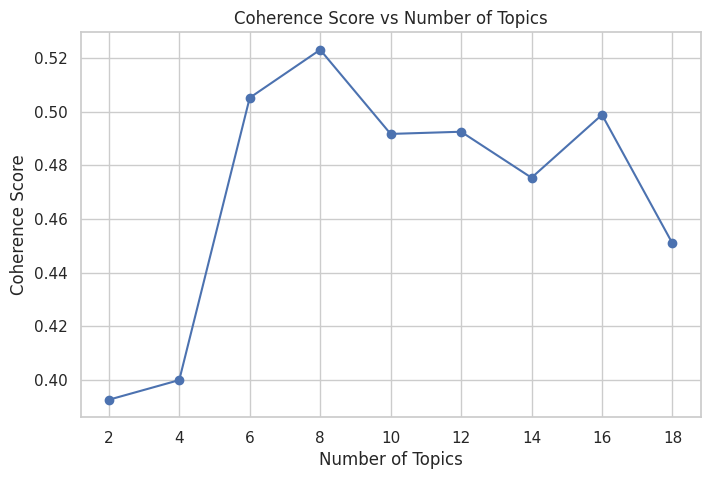

Best number of topics: 8


In [70]:
topic_range, coherences = plot_coherence_vs_topics(texts)

# Find the best number of topics
max_index = coherences.index(max(coherences))
best_num_topics = topic_range[max_index]

print(f"Best number of topics: {best_num_topics}")

In [71]:
# LDA Topic Modeling Function

def perform_topic_modeling(texts, num_topics=best_num_topics, passes=30):
    tokenized_docs = [clean_text(text) for text in texts.values()]
    dictionary = corpora.Dictionary(tokenized_docs)
    dictionary.filter_extremes(no_below=5, no_above=0.5)
    corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

    lda_model = models.LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        passes=passes,
        alpha='symmetric',
        eta='auto',
        random_state=42
    )

    coherence_model = CoherenceModel(model=lda_model, texts=tokenized_docs, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()

    print(f"Coherence Score: {coherence_score:.4f}")
    for idx, topic in lda_model.print_topics():
        print(f"Topic {idx}: {topic}")

    return lda_model, corpus, dictionary, tokenized_docs


Applying the model to the tokenized text we can notice many entites and organizations appearing in the topic porbability calculation. The coherence score is 0.47, which can be adequate, however this can be improved to fit the research better.

In [72]:
lda_model, corpus, dictionary, tokenized_docs = perform_topic_modeling(texts)

Coherence Score: 0.5232
Topic 0: 0.022*"representation" + 0.019*"centric" + 0.014*"attack" + 0.014*"ico" + 0.012*"dpa" + 0.011*"customer" + 0.011*"para" + 0.009*"server" + 0.009*"tribunal" + 0.009*"rap"
Topic 1: 0.092*"edpb" + 0.069*"objection" + 0.062*"meta" + 0.024*"sas" + 0.020*"child" + 0.019*"instagram" + 0.018*"guideline" + 0.015*"legitimate" + 0.014*"bind" + 0.014*"lsa"
Topic 2: 0.012*"department" + 0.010*"child" + 0.009*"reprimand" + 0.009*"guideline" + 0.009*"training" + 0.008*"commencement" + 0.008*"appendix" + 0.006*"recipient" + 0.006*"health" + 0.006*"testing"
Topic 3: 0.087*"cctv" + 0.071*"camera" + 0.036*"garda" + 0.023*"traffic" + 0.022*"centre" + 0.019*"monitoring" + 0.016*"síochána" + 0.013*"surveillance" + 0.011*"authorise" + 0.011*"authorisation"
Topic 4: 0.081*"meta" + 0.043*"edpb" + 0.029*"judgment" + 0.024*"cjeu" + 0.014*"country" + 0.014*"charter" + 0.012*"clause" + 0.012*"derogation" + 0.010*"sas" + 0.009*"eea"
Topic 5: 0.026*"ico" + 0.023*"confidential" + 0.02

## Further processing using NER

Identifying the entities influence over the output of the modelm first I'd like to check for the organizations, geopolitical entitities and money for data validation.

In [73]:
# Named Entity Recognition (NER)
def extract_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents if ent.label_ in ['ORG', 'GPE', 'MONEY']]

for filename, text in texts.items():
    entities = extract_entities(text)
    top_entities = pd.Series([ent[0] for ent in entities]).value_counts().head(20)
    print(f"\n📄 {filename} → {top_entities.to_dict()}")



📄 ETid-930.pdf → {'the Cabinet Office': 37, 'The Cabinet Office': 27, 'GDPR': 24, 'CSV': 24, 'Cabinet Office': 14, 'the Press Office': 13, 'Honours': 11, 'ICO': 10, 'DPA': 8, 'HAS': 8, "The Cabinet Office's": 7, 'Tribunal': 7, "the Cabinet Office's": 6, 'GOV.eUK': 5, '500,000': 4, "the Cabinet \nOffice's": 4, 'the HAS Operations Team': 4, 'GDS': 4, 'the Digital Team': 4, 'UK': 3}

📄 ETid-2484.pdf → {'MPIL': 8, 'Irish Data Protection Commission': 7, 'Meta': 6, 'DPC': 6, '€251 Million': 5, 'Data Protection Commission': 5, 'EU': 3, '€251 million': 2, 'The Irish Data Protection Commission': 1, 'Meta\nPlatforms Ireland Limited': 1, 'GDPR': 1, 'Commissioners for Data Protection': 1, 'US': 1, '€8 million': 1, 'EEA': 1, 'the Supervisory Authority': 1, '€3\nmillion': 1, '€130 million': 1, '€110 million': 1, 'the Lead Supervisory Authority': 1}

📄 ETid-1564.pdf → {'VIEC': 221, 'GDPR': 34, 'Inquiry': 13, 'EU': 11, 'DPC': 7, 'Response to Commission Queries': 4, 'the Draft Decision': 4, 'Commencem

After identifying the entities above, I further filtered the texts to only include words containing at least 3 characters.

In [74]:
def clean_text(text):
    doc = nlp(text.lower())
    tokens = [
        token.lemma_ for token in doc
        if token.is_alpha and not token.is_stop and len(token) > 4
    ]
    return tokens

Building on the function above, to filter the tokens further using NER.

In [75]:
# Modified NER Function: Return only entities to remove

def get_entities_to_remove(text):
    doc = nlp(text)
    return [ent.text for ent in doc.ents if ent.label_ in ['ORG', 'GPE']]

# Remove NER entities from text
def remove_entities(text, entities):
    for ent in entities:
        text = text.replace(ent, '')
    return text

# Process all documents
cleaned_texts = {}
for filename, text in texts.items():
    entities_to_remove = get_entities_to_remove(text)
    cleaned = remove_entities(text, entities_to_remove)
    cleaned_texts[filename] = cleaned

In [76]:
def normalize_whitespace(text):
    return re.sub(r'\s+', ' ', text).strip()

Rerunning the optimal topic number finder as the texts have changed

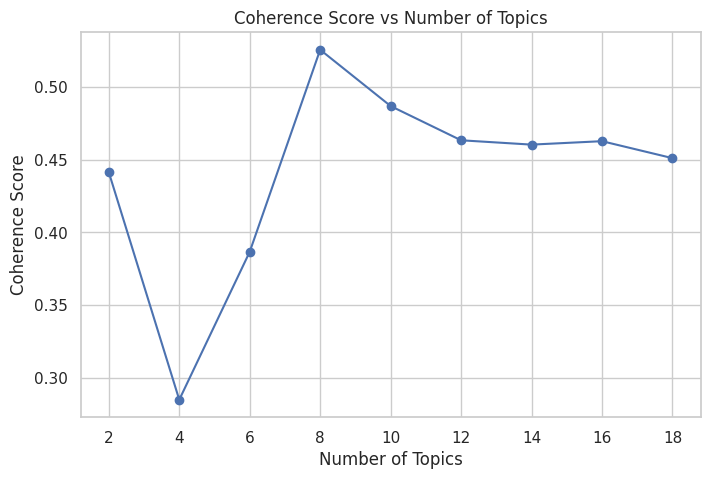

Best number of topics: 8


In [77]:
topic_range_cleaned, coherences_cleaned = plot_coherence_vs_topics(cleaned_texts)

max_index_cleaned = coherences_cleaned.index(max(coherences_cleaned))
best_num_topics = topic_range_cleaned[max_index_cleaned]

print(f"Best number of topics: {best_num_topics}")

In [78]:
lda_model_cleaned, corpus_cleaned, dictionary_cleaned, tokenized_docs_cleaned = perform_topic_modeling(cleaned_texts,best_num_topics,30)

Coherence Score: 0.5257
Topic 0: 0.116*"camera" + 0.055*"garda" + 0.032*"centre" + 0.028*"monitoring" + 0.028*"traffic" + 0.020*"surveillance" + 0.017*"authorisation" + 0.016*"authorise" + 0.015*"instal" + 0.014*"lawful"
Topic 1: 0.014*"representation" + 0.014*"attack" + 0.010*"vulnerability" + 0.009*"contravention" + 0.009*"training" + 0.009*"server" + 0.008*"software" + 0.007*"payment" + 0.007*"attacker" + 0.007*"monetary"
Topic 2: 0.032*"publication" + 0.029*"confidential" + 0.027*"alert" + 0.018*"exfiltrate" + 0.014*"penetration" + 0.012*"entity" + 0.012*"privilege" + 0.010*"undertaking" + 0.010*"maximum" + 0.010*"compromise"
Topic 3: 0.065*"customer" + 0.026*"official" + 0.024*"confidential" + 0.018*"threat" + 0.015*"actor" + 0.013*"credential" + 0.013*"representation" + 0.012*"download" + 0.011*"attack" + 0.011*"password"
Topic 4: 0.077*"child" + 0.024*"objection" + 0.015*"setting" + 0.015*"platform" + 0.012*"phone" + 0.011*"private" + 0.010*"publication" + 0.010*"profile" + 0.01

# Result analysis

## Assigning dominant topics to documents and visualization

In [79]:
import glob

# Adjust the folder path as needed
pdf_folder = "gdpr_pdfs"
pdf_files = glob.glob(os.path.join(pdf_folder, "*.pdf"))

Applying the dominant topics to the documents and saving it to a csv.

In [80]:
# Assign dominant topic to each document
dominant_topics = []
filenames = list(texts.keys())  # assuming 'texts' is a dict {filename: text}

for i, bow in enumerate(corpus_cleaned):
    topic_dist = lda_model_cleaned.get_document_topics(bow)
    top_topic = max(topic_dist, key=lambda x: x[1])  # (topic_id, confidence)
    dominant_topics.append({
        "Filename": os.path.basename(filenames[i]).replace(".pdf", ""),
        "Dominant_Topic": top_topic[0],
        "Topic_Confidence": top_topic[1]
    })

# Convert to DataFrame
doc_topics_df = pd.DataFrame(dominant_topics)
doc_topics_df.set_index("Filename", inplace=True)

# Show result
print(doc_topics_df)
doc_topics_df.to_csv('doc_topics.csv')

           Dominant_Topic  Topic_Confidence
Filename                                   
ETid-930                1          0.734307
ETid-2484               4          0.627904
ETid-1564               7          0.907125
ETid-893                3          0.361810
ETid-1677               7          0.636986
ETid-1910               6          0.488494
ETid-1009               0          0.773089
ETid-2561               1          0.482472
ETid-2566               1          0.541233
ETid-2885               1          0.598452
ETid-2657               1          0.732611
ETid-60                 1          0.808950
ETid-2032               4          0.999446
ETid-1190               3          0.965859
ETid-875                6          0.996591
ETid-2684               7          0.414115
ETid-1696               7          0.751312
ETid-2780               7          0.732755
ETid-1373               4          0.801121
ETid-570                7          0.999573
ETid-1844               6       

In [81]:
merged = doc_topics_df.merge(metadata_df_cleaned, left_index=True, right_on='ETid', how='left')
merged.head()


,Dominant_Topic,Topic_Confidence,ETid,Country,Authority,Date of Decision,Fine [€],Controller/Processor,Sector,Quoted Art.,Type,Summary
68,1,0.734307,ETid-930,UNITED KINGDOM,Information Commissioner (ICO),2021-11-25 00:00:00,585000,Cabinet Office,Public Sector and Education,"[5 (1) f) GDPR, 32 GDPR]",Insufficient technical and organisational meas...,The UK DPA (ICO) has fined the Cabinet Office ...
22,4,0.627904,ETid-2484,IRELAND,Data Protection Authority of Ireland,2024-12-17 00:00:00,251000000,Meta Platforms Ireland Limited,"Media, Telecoms and Broadcasting","[33 (3), (5) GDPR, 25 (1), (2) GDPR]",Insufficient technical and organisational meas...,The Irish Data Protection Commission (DPC) has...
32,7,0.907125,ETid-1564,IRELAND,Data Protection Authority of Ireland,2022-12-22 00:00:00,100000,VIEC Limited,Industry and Commerce,"[5 (1) f) GDPR, 32 (1) GDPR]",Non-compliance with general data processing pr...,"The Irish DPA has imposed a fine of EUR 100,00..."
41,3,0.361810,ETid-893,IRELAND,Data Protection Authority of Ireland,2021-08-20 00:00:00,1500,MOVE Ireland,Individuals and Private Associations,"[5 (1) f) GDPR, 32 (1) GDPR]",Insufficient technical and organisational meas...,The Irish DPA (DPC) has fined the organization...
29,7,0.636986,ETid-1677,IRELAND,Data Protection Authority of Ireland,2022-12-30 00:00:00,15000,A&G Couriers Limited T/A Fastway Couriers (Ire...,Transportation and Energy,[32 (1) GDPR],Insufficient technical and organisational meas...,The Irish DPA (DPC) has fined A&G Couriers Lim...


In [82]:
merged.to_csv('merged.csv')

A simple plot showing the topic confidence of each case comparing to fine amount.

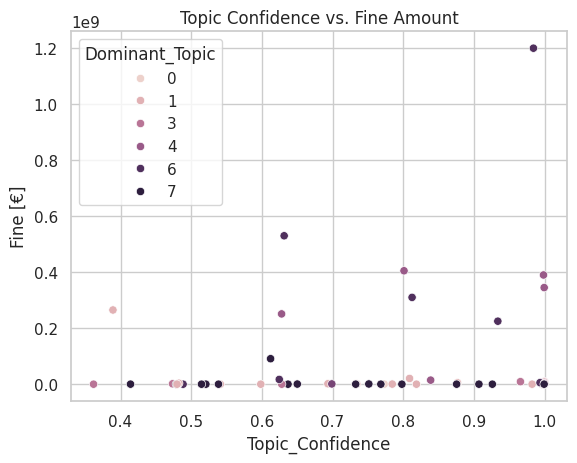

In [83]:
# Creating plots using the merged data
sns.scatterplot(data=merged, x='Topic_Confidence', y='Fine [€]', hue='Dominant_Topic')
plt.title('Topic Confidence vs. Fine Amount')
plt.show()

Box plots are created to illustrate the distribution of each topic and fine amount. The second box plot uses the logaritmic scale to illustrate the plot better in the large range of fines.

/tmp/ipython-input-84-3557207229.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged, x='Dominant_Topic', y='Fine [€]', palette='viridis')
/tmp/ipython-input-84-3557207229.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=merged, x='Dominant_Topic', palette='Set2')


Text(0.5, 0, 'Dominant Topic')

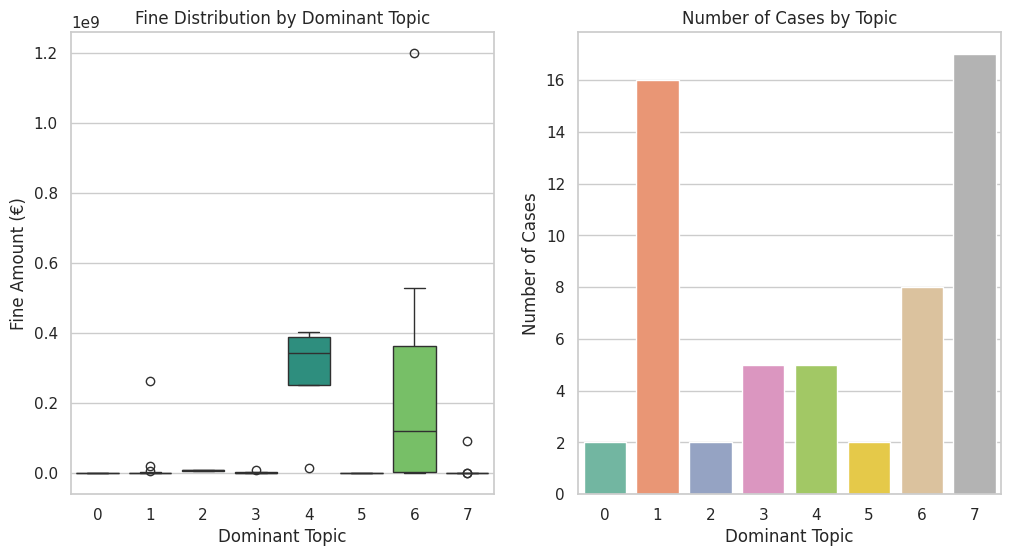

In [84]:
# Create visualizations
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Plot 1: Fine Amounts by Topic
plt.subplot(1, 2, 1)
sns.boxplot(data=merged, x='Dominant_Topic', y='Fine [€]', palette='viridis')
plt.title("Fine Distribution by Dominant Topic")
plt.ylabel("Fine Amount (€)")
plt.xlabel("Dominant Topic")

# Plot 2: Number of Cases per Topic
plt.subplot(1, 2, 2)
sns.countplot(data=merged, x='Dominant_Topic', palette='Set2')
plt.title("Number of Cases by Topic")
plt.ylabel("Number of Cases")
plt.xlabel("Dominant Topic")

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipython-input-85-830188798.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged, x='Dominant_Topic', y='Log_Fine', palette='coolwarm')
/tmp/ipython-input-85-830188798.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_fines, x='Dominant_Topic', y='Fine [€]', palette='mako')


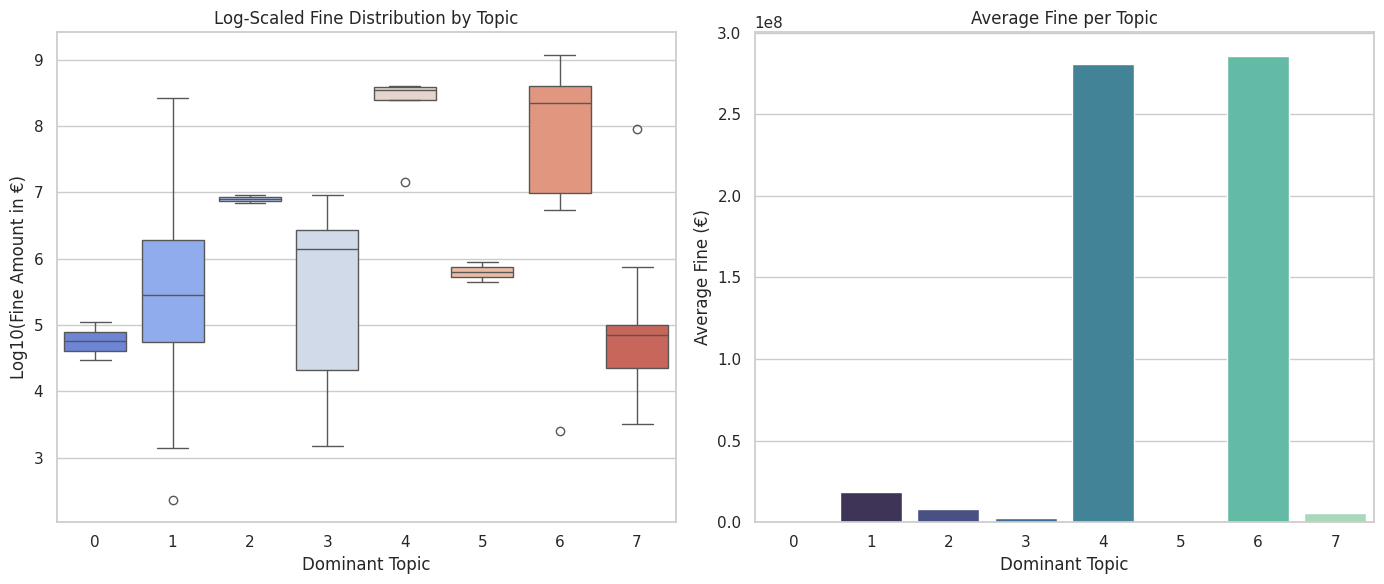

In [85]:
import numpy as np
# Log-transform fine amounts
merged['Log_Fine'] = np.log10(merged['Fine [€]'])

# Set up plots
plt.figure(figsize=(14, 6))

# Boxplot with log-scaled fines
plt.subplot(1, 2, 1)
sns.boxplot(data=merged, x='Dominant_Topic', y='Log_Fine', palette='coolwarm')
plt.title("Log-Scaled Fine Distribution by Topic")
plt.ylabel("Log10(Fine Amount in €)")
plt.xlabel("Dominant Topic")

# Average fine per topic (bar)
plt.subplot(1, 2, 2)
mean_fines = merged.groupby('Dominant_Topic')['Fine [€]'].mean().reset_index()
sns.barplot(data=mean_fines, x='Dominant_Topic', y='Fine [€]', palette='mako')
plt.title("Average Fine per Topic")
plt.ylabel("Average Fine (€)")
plt.xlabel("Dominant Topic")

plt.tight_layout()
plt.show()

## Returning the top terms for each topic



Using pyLDAvis, the top 10 words are returned from the topics with the how the term contributed to the topic.

/tmp/ipython-input-86-2077945568.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='probability', y='word', data=df, palette='viridis')


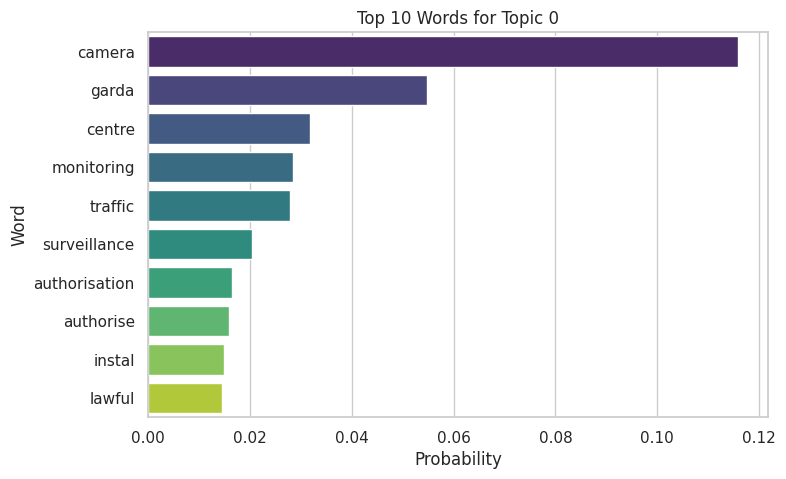

/tmp/ipython-input-86-2077945568.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='probability', y='word', data=df, palette='viridis')


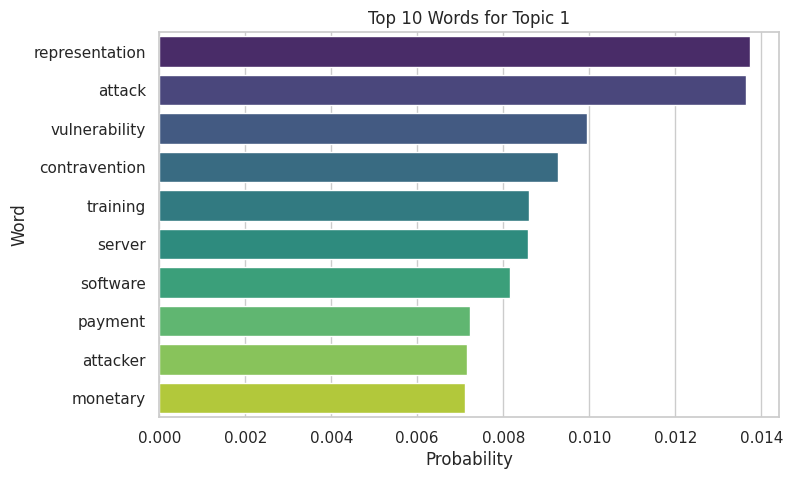

/tmp/ipython-input-86-2077945568.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='probability', y='word', data=df, palette='viridis')


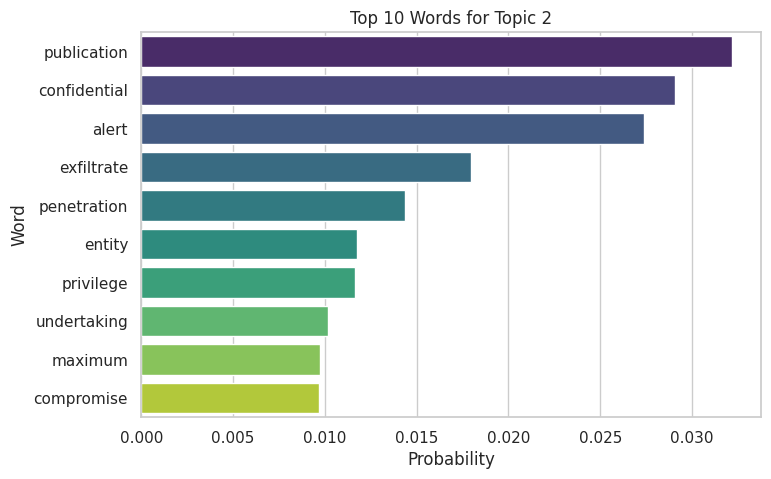

/tmp/ipython-input-86-2077945568.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='probability', y='word', data=df, palette='viridis')


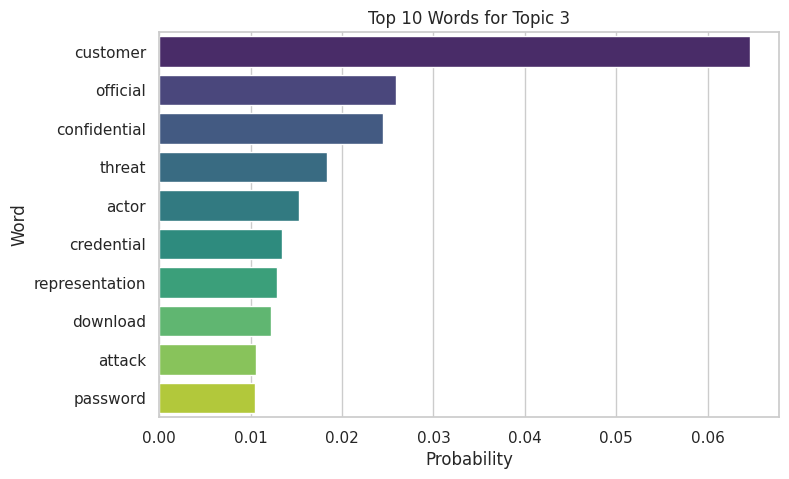

/tmp/ipython-input-86-2077945568.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='probability', y='word', data=df, palette='viridis')


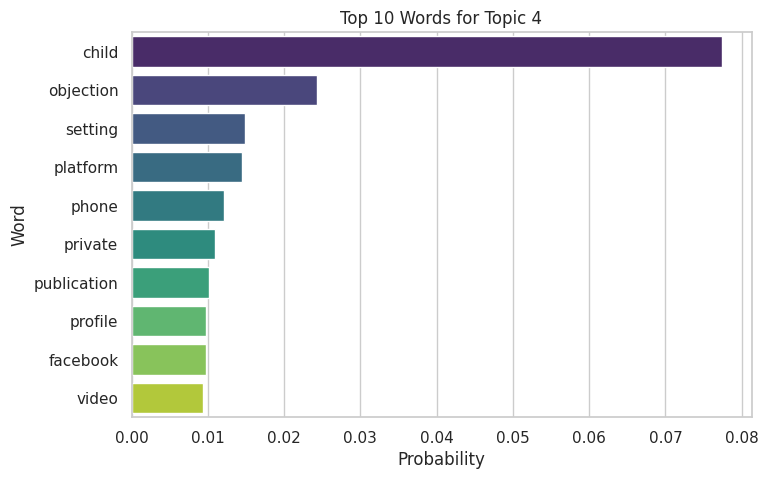

/tmp/ipython-input-86-2077945568.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='probability', y='word', data=df, palette='viridis')


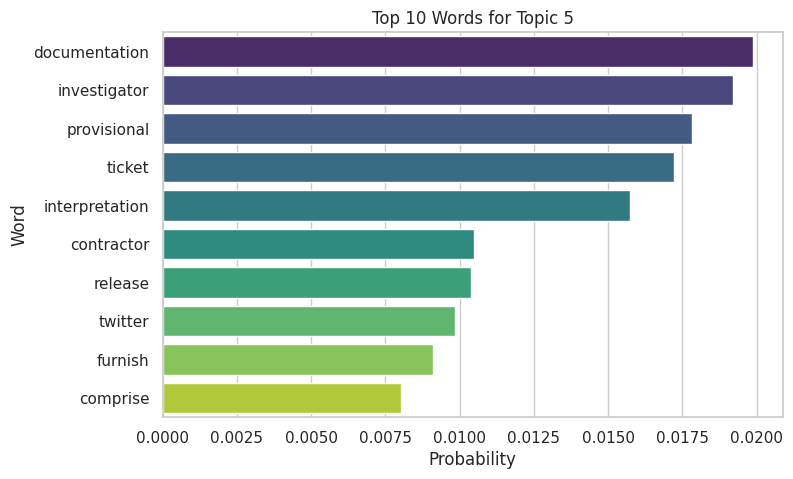

/tmp/ipython-input-86-2077945568.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='probability', y='word', data=df, palette='viridis')


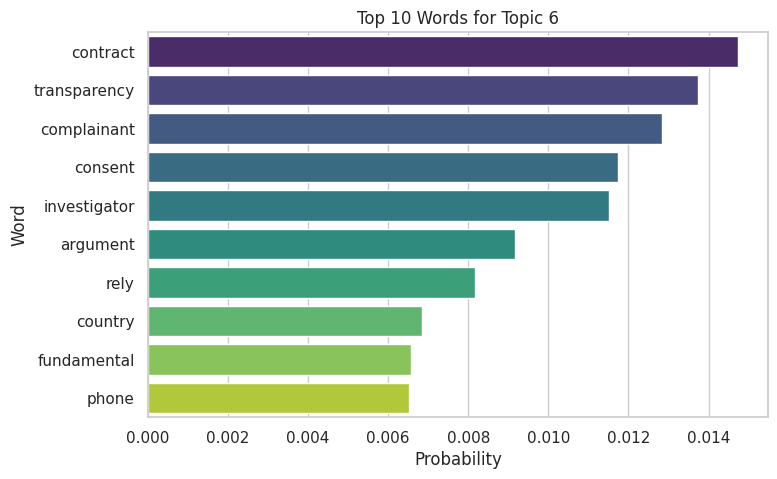

/tmp/ipython-input-86-2077945568.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='probability', y='word', data=df, palette='viridis')


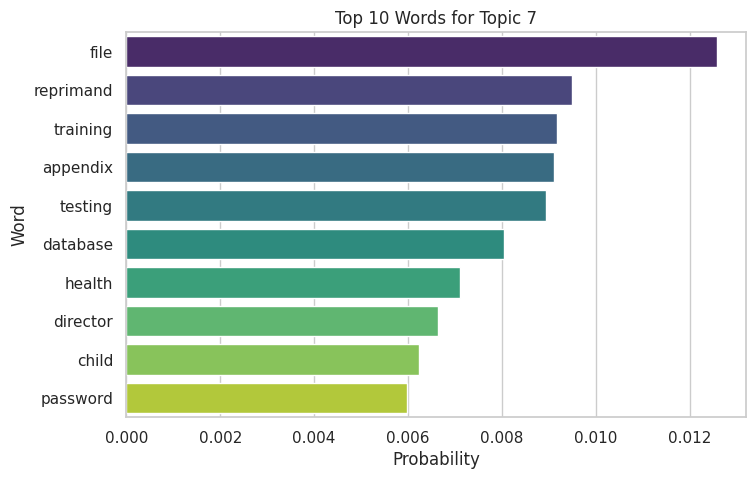

In [86]:
# Function to get top words for each topic
def plot_top_words(lda_model, num_words=10):
    for topic_id in range(lda_model.num_topics):
        words_probs = lda_model.show_topic(topic_id, topn=num_words)
        words, probs = zip(*words_probs)
        df = pd.DataFrame({'word': words, 'probability': probs})
        plt.figure(figsize=(8, 5))
        sns.barplot(x='probability', y='word', data=df, palette='viridis')
        plt.title(f"Top {num_words} Words for Topic {topic_id}")
        plt.xlabel("Probability")
        plt.ylabel("Word")
        plt.show()

plot_top_words(lda_model_cleaned)


Calculating the correlation between the topic_confidence and fines.

In [87]:
merged["log_fine"] = np.log1p(merged["Fine [€]"])

In [88]:
from sklearn.linear_model import LinearRegression
import numpy as np

X = merged[["Dominant_Topic"]]   # predictor
y = merged["log_fine"]              # target

model = LinearRegression()
model.fit(X, y)

print("Coefficient:", model.coef_[0])
print("Intercept:", model.intercept_)
print("R²:", model.score(X, y))

Coefficient: -0.05978186334043727
Intercept: 13.358896613489234
R²: 0.0013350886835913345


In [89]:
import statsmodels.api as sm

In [90]:
df = merged

# Show dtypes first for diagnosis
dtypes_before = df.dtypes

# Clean column names
df = df.rename(columns={"Fine [€]": "Fine", "Dominant_Topic": "Topic"})

# Convert
df["Fine"] = pd.to_numeric(df["Fine"], errors="coerce")
df["Topic"] = pd.to_numeric(df["Topic"], errors="coerce").astype("category")

# Drop missing fines
df = df.dropna(subset=["Fine"])

# Log transform
df["log_fine"] = np.log1p(df["Fine"])

# Dummy encode topic
X = pd.get_dummies(df["Topic"], drop_first=True).astype(float)

# Add constant
X = sm.add_constant(X)

y = df["log_fine"].astype(float)

# Fit model
model = sm.OLS(y, X).fit()

dtypes_after = X.dtypes
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               log_fine   R-squared:                       0.294
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                     2.915
Date:                Wed, 03 Dec 2025   Prob (F-statistic):             0.0125
Time:                        16:26:39   Log-Likelihood:                -152.77
No. Observations:                  57   AIC:                             321.5
Df Residuals:                      49   BIC:                             337.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.9502      2.692      4.068      0.0

Statistics to show the topic_confidence influenced the median fines given to each topic categorized into 4 bins.

In [91]:
# Assuming 'merged_df' contains your data
grouped_df = merged.groupby(['Dominant_Topic', pd.cut(merged['Topic_Confidence'], bins=4, )])['Fine [€]'].median()

pd.set_option('display.float_format', '{:.2f}'.format)

print(grouped_df)

Dominant_Topic  Topic_Confidence
0               (0.361, 0.521]              NaN
                (0.521, 0.681]              NaN
                (0.681, 0.84]         110000.00
                (0.84, 1.0]            29500.00
1               (0.361, 0.521]       1851000.00
                (0.521, 0.681]         35265.00
                (0.681, 0.84]         567500.00
                (0.84, 1.0]           103000.00
2               (0.361, 0.521]              NaN
                (0.521, 0.681]              NaN
                (0.681, 0.84]               NaN
                (0.84, 1.0]          8030000.00
3               (0.361, 0.521]        703250.00
                (0.521, 0.681]         20725.00
                (0.681, 0.84]               NaN
                (0.84, 1.0]          5850000.00
4               (0.361, 0.521]              NaN
                (0.521, 0.681]     251000000.00
                (0.681, 0.84]      209750000.00
                (0.84, 1.0]        367500000.00
5      

/tmp/ipython-input-91-521693314.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = merged.groupby(['Dominant_Topic', pd.cut(merged['Topic_Confidence'], bins=4, )])['Fine [€]'].median()


## Random model for comparison

Initalizing model, getting the same parameters to use as the LDA model.

In [92]:
class RandomTopicModel:
    def __init__(self, num_topics, vocab_size):
        self.num_topics = num_topics
        self.vocab_size = vocab_size

    def get_topics(self):
        # Return a uniform distribution for each topic across all vocab terms
        return np.ones((self.num_topics, self.vocab_size)) / self.vocab_size


In [93]:
random_model = RandomTopicModel(num_topics=lda_model_cleaned.num_topics, vocab_size=len(dictionary_cleaned))

Applying both models to return the coherence scores.

In [94]:
lda_coherence_model = CoherenceModel(model=lda_model_cleaned, texts=tokenized_docs_cleaned, dictionary=dictionary_cleaned, coherence='c_v')
lda_coherence = lda_coherence_model.get_coherence()

random_coherence_model = CoherenceModel(model=random_model, texts=tokenized_docs_cleaned, dictionary=dictionary_cleaned, coherence='c_v')
random_coherence = random_coherence_model.get_coherence()


Plotting the two models against eachother.

LDA Coherence: 0.5256677900112237
Random Coherence: 0.6840927575014067


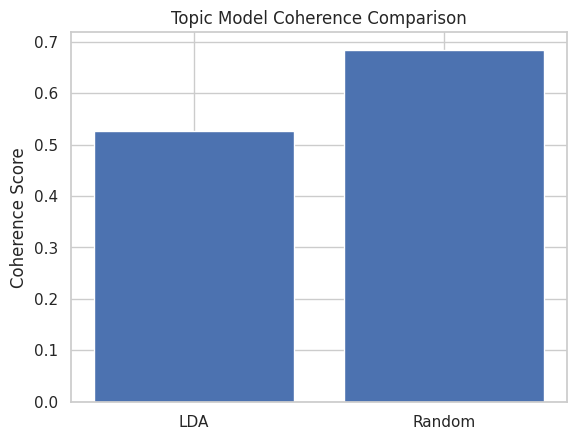

In [95]:
print(f"LDA Coherence: {lda_coherence}")
print(f"Random Coherence: {random_coherence}")

plt.bar(['LDA', 'Random'], [lda_coherence, random_coherence])
plt.title('Topic Model Coherence Comparison')
plt.ylabel('Coherence Score')
plt.show()

## pyLDAvis visualization

Initializing the pyLDAvis on the cleaned model for interactive visualization. This gives us the ability to view each topic individually and adjust the topic confidence to see what words would be included.

In [96]:
def visualize_topics(lda_model, corpus, dictionary):
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary, sort_topics=False)
    return vis  # Use pyLDAvis.display(vis) or pyLDAvis.save_html(vis, 'lda.html')

In [97]:
visualize_topics(lda_model_cleaned, corpus_cleaned, dictionary_cleaned)

PreparedData(topic_coordinates=          x     y  topics  cluster  Freq
topic                                   
0      0.31 -0.16       1        1  4.43
1     -0.11 -0.08       2        1 10.13
2     -0.15 -0.11       3        1  9.60
3     -0.13 -0.09       4        1  7.98
4      0.04  0.14       5        1 17.88
5     -0.01  0.14       6        1  7.39
6      0.08  0.13       7        1 27.93
7     -0.02  0.04       8        1 14.65, topic_info=                Term    Freq   Total Category  logprob  loglift
403            child 1554.00 1554.00  Default    30.00    30.00
1141          camera  534.00  534.00  Default    29.00    29.00
521         customer  602.00  602.00  Default    28.00    28.00
587            garda  274.00  274.00  Default    27.00    27.00
1441    confidential  516.00  516.00  Default    26.00    26.00
...              ...     ...     ...      ...      ...      ...
739           retain   54.59  103.04   Topic8    -5.62     1.29
422            grave   57.11  143.75   Topic8    -5.57     1.00
403            child   93.39 1554.23   Topic8    -5.08    -0.89
90    correspondence   56.51  188.13   Topic8    -5.58     0.72
305         restrict   53.58  132.73   Topic8    -5.63     1.01

[471 rows x 6 columns], token_table=      Topic  Freq        Term
term                         
0         2  0.04  acceptance
0         5  0.02  acceptance
0         7  0.91  acceptance
0         8  0.02  acceptance
2         1  0.14  accessible
...     ...   ...         ...
1913      4  0.04      worker
1913      8  0.83      worker
1515      2  0.12       young
1515      5  0.77       young
1515      8  0.09       young

[1776 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8])

## Saving the model


In [98]:
lda_model_cleaned.save('lda.model')